# Overall ML Training Workflow

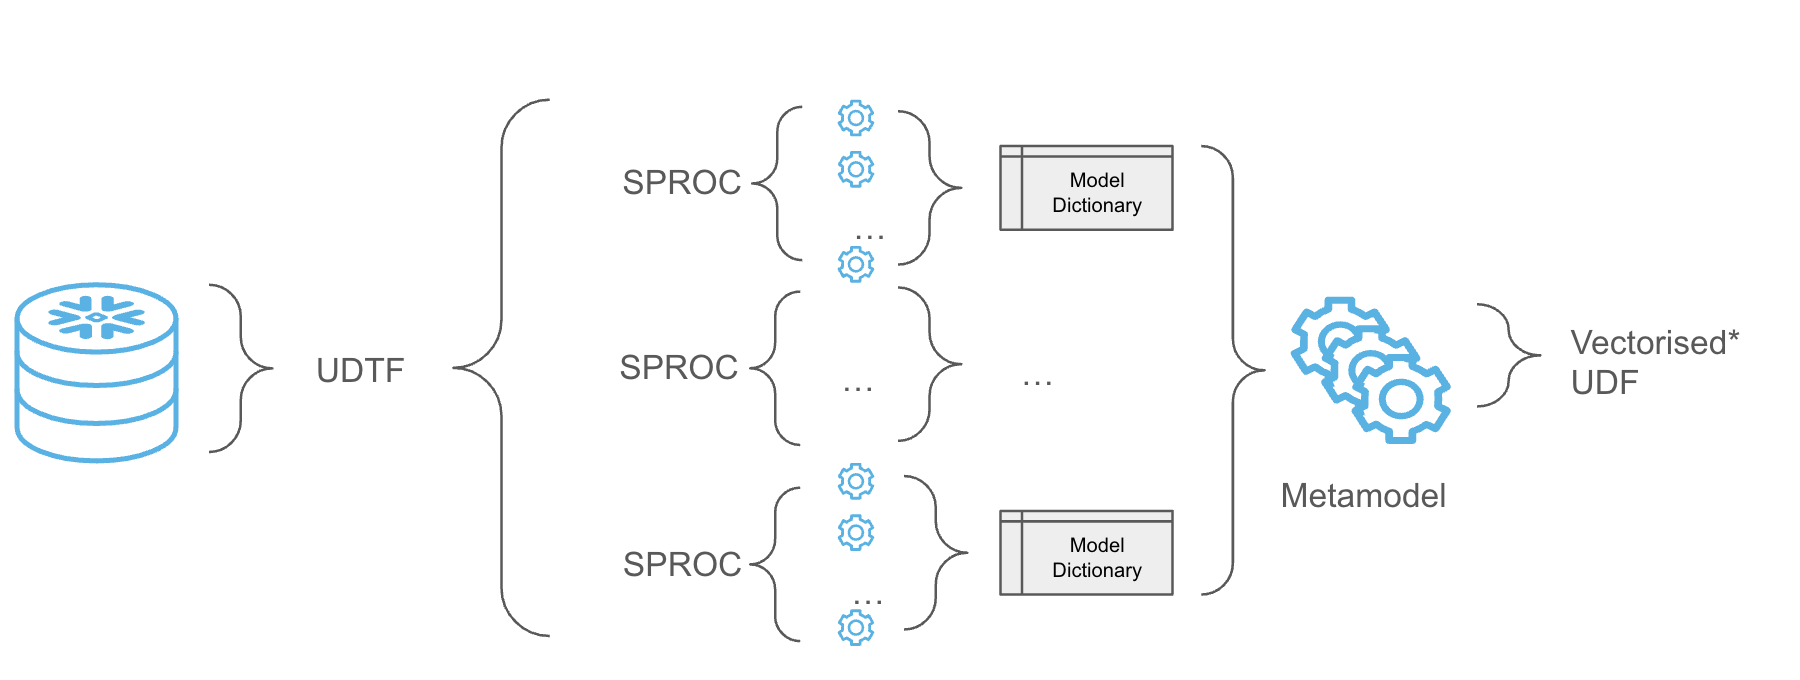

In [1]:
from IPython.display import Image
Image("E2Eorkflow.png")

In [3]:
import json
import numpy as np
import pandas as pd
import os
import sys
from cachetools import cached
from snowflake.snowpark.session import Session
from snowflake.snowpark.functions import sproc, col
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T

from snowflake.snowpark.types import PandasDataFrameType, IntegerType, StringType, FloatType
from snowflake.snowpark.exceptions import SnowparkSQLException


# Log In, Create Session

In [4]:
# Reading Snowflake Connection Details
snowflake_connection_cfg = json.loads(open("/Users/mitaylor/Documents/creds/creds.json").read())

# Creating Snowpark Session
session = Session.builder.configs(snowflake_connection_cfg).create()

In [5]:
# Create a fresh & new schema
#session.sql("CREATE OR REPLACE DATABASE ASYNC_DEMO").collect()
session.sql("USE DATABASE ASYNC_DEMO").collect()
session.sql("CREATE OR REPLACE STAGE ML_MODELS").collect()

[Row(status='Stage area ML_MODELS successfully created.')]

In [6]:
session.sql("CREATE OR REPLACE WAREHOUSE ASYNC_WH WITH WAREHOUSE_SIZE='MEDIUM' WAREHOUSE_TYPE = 'SNOWPARK-OPTIMIZED'").collect()

[Row(status='Warehouse ASYNC_WH successfully created.')]

# Get the Data From the Share, Examine it, and Save it (or from your database)

In [20]:
sdf = session.sql("select * FROM DATA_LAKE_TRADE_DATA_MT.PUBLIC.TRADE")
# sdf.write.save_as_table("TEST", mode="overwrite")
sdf.limit(5).to_pandas()

,DATE,SYMBOL,EXCHANGE,ACTION,CLOSE,NUM_SHARES,CASH,TRADER,PM
0,2000-08-29,SLAB,NASDAQ,buy,62.00,24.0,-1488.00,Gary Jones,Ruth Ahmed
1,2000-08-30,SLAB,NASDAQ,buy,61.00,24.0,-1464.00,Gary Jones,Ruth Ahmed
2,2000-08-31,SLAB,NASDAQ,buy,60.38,24.0,-1449.12,Gary Jones,Ruth Ahmed
3,2000-09-01,SLAB,NASDAQ,buy,61.12,24.0,-1466.88,Gary Jones,Ruth Ahmed
4,2000-09-05,SLAB,NASDAQ,buy,60.25,25.0,-1506.25,Gary Jones,Ruth Ahmed


# Prepare the Data for Machine Learning (using a UDTF)

In [21]:
sdf_symbols = list(session.sql('select distinct SYMBOL FROM DATA_LAKE_TRADE_DATA_MT.PUBLIC.TRADE').to_pandas()['SYMBOL'])
len(sdf_symbols)

9442

In [22]:
test_symbols = sdf_symbols[:5000]

In [23]:
from snowflake.snowpark.types import PandasDataFrameType, IntegerType, StringType, FloatType, DateType

n_in = 10
feature_cols = ['TM' + str(i) for i in range(0,n_in+1)]
feature_cols.reverse()

schema = [FloatType()]*(n_in+1) + [IntegerType(),DateType(),StringType()]
headers = feature_cols + [ "Y", "DATE_", "SYMBOL_"]

class ML_Prep:
    """
    UDTF class to create offset time series data for binary classification

    Yields
    -------
    df_new : DataFrame
        DataFrame with the TMx,TMx-1,...,TM0 data plus the y variable 

    """
    def __init__(self):
        None
        
    def end_partition(self, df):
        df.columns = ['DATE', 'SYMBOL', 'CLOSE']
        dates = df['DATE']
        symbol = df['SYMBOL']
        df = df['CLOSE']

        def series_to_supervised(df, n_in=n_in, n_out=1, dropnan=True):
            cols = list()
            # input sequence (t-n, ... t-1)
            for i in range(n_in, 0, -1):
                cols.append(df.shift(i))
            for i in range(0, n_out):
                cols.append(df.shift(-i))
            agg = pd.concat(cols, axis=1)
            
            # drop rows with NaN values
            df = pd.DataFrame(agg.values)
            df = df.fillna(df.mean())
            columns = ["TM" + str(i) for i in range(0,n_in+1)]
            columns.reverse()
            df.columns = columns 
            df['y'] = df['TM0'] - df['TM1']
            df['y'] = [1 if i>0 else 0 for i in list(df['y'])]
            return df
        df_new = series_to_supervised(df)
        df_new['DATE'] = dates
        df_new['SYMBOL'] = symbol
        yield df_new

ML_Prep.end_partition._sf_vectorized_input = pd.DataFrame

ml_prep_udtf = session.udtf.register(
    ML_Prep, # the class
    input_types=[PandasDataFrameType([DateType()] + # DATE
                                     [StringType()] + # SYMBOL
                                     [FloatType()] # CLOSE
                                    )], 
    output_schema = PandasDataFrameType(schema, headers),
    packages=["snowflake-snowpark-python", 'pandas'])  



The version of package 'snowflake-snowpark-python' in the local environment is 1.10.0, which does not fit the criteria for the requirement 'snowflake-snowpark-python'. Your UDF might not work when the package version is different between the server and your local environment.


In [24]:
df_for_in = session.create_dataframe([[i] for i in list(test_symbols)], schema=["col1"])
sdf_filtered = sdf.filter(sdf["SYMBOL"].in_(df_for_in)).sort(sdf["SYMBOL"].asc())

In [25]:
all_cols = ['DATE', 'SYMBOL', 'CLOSE']
sdf_prepped = sdf_filtered.select(ml_prep_udtf(*all_cols).over(partition_by=['SYMBOL']))
sdf_prepped.limit(5).to_pandas()

,TM10,TM9,TM8,TM7,TM6,TM5,TM4,TM3,TM2,TM1,TM0,Y,DATE_,SYMBOL_
0,9.863743,9.863749,9.86374,9.863755,9.863749,9.863764,9.863783,9.863776,9.863766,9.863756,9.840,0,2022-09-26,TBCP
1,9.863743,9.863749,9.86374,9.863755,9.863749,9.863764,9.863783,9.863776,9.863766,9.840000,9.865,1,2022-10-04,TBCP
2,9.863743,9.863749,9.86374,9.863755,9.863749,9.863764,9.863783,9.863776,9.840000,9.865000,9.840,0,2022-09-20,TBCP
3,9.863743,9.863749,9.86374,9.863755,9.863749,9.863764,9.863783,9.840000,9.865000,9.840000,9.870,1,2022-10-05,TBCP
4,9.863743,9.863749,9.86374,9.863755,9.863749,9.863764,9.840000,9.865000,9.840000,9.870000,9.840,0,2022-09-21,TBCP


In [26]:
sdf_prepped = sdf_prepped.drop_duplicates(['SYMBOL_', 'DATE_'])

In [27]:
%%time
sdf_prepped.write.save_as_table("ASYNC_TEST", mode="overwrite")

CPU times: user 1.83 s, sys: 260 ms, total: 2.09 s
Wall time: 1h 53min 42s


In [28]:
sdf_100 = session.sql("""WITH TOP100 AS (
 SELECT *, ROW_NUMBER() 
    over (
        PARTITION BY SYMBOL_
        order by DATE_
    ) AS RowNo 
    FROM ASYNC_TEST
)
SELECT * FROM TOP100 WHERE RowNo <= 100""")

In [29]:
%%time
sdf_100.write.save_as_table("ML100", mode="overwrite")

CPU times: user 13.2 ms, sys: 2.74 ms, total: 16 ms
Wall time: 2.35 s


# Create and Train an ML Model to Predict Price Direction

In [30]:
# Note this SPROC is identical to the one below, but in order to enable async calls you must call directly via sql, and hence the python lists must be converted to strings as inputs (see feature_cols and symbols).

@sproc(session=session, name='train_models_old', stage_location='@ML_MODELS',  
       packages=['snowflake-snowpark-python', 'scikit-learn', 'numpy'], 
       is_permanent=True, 
       replace=True)
def train_models_old(session: Session, train_table: str, feature_cols: list, target_col: str, symb_col_name: str, symbols: list, dict_name: str) -> str:
    """
    Trains multiple models, one for each symbol, via a for loop.  Note this is linear, but can be parallelised
    by multiple asynchcronous calls of the same sproc (but with different 
    """
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestClassifier
    from joblib import dump
    
    model_dict = {}
    total_len = 0
    for symbol in symbols:
        sdf = session.table(train_table)
        local_training_data = sdf.filter((col(symb_col_name) == symbol)).to_pandas()
        X,y = local_training_data[feature_cols], local_training_data[target_col]
        clf = RandomForestClassifier(max_depth=3, random_state=0, n_estimators=50)
        clf.fit(X, y)
        model_dict[symbol] = clf
        total_len += len(y)
    dump(model_dict, '/tmp/'+dict_name)
    session.file.put('/tmp/'+dict_name, '@ML_MODELS', auto_compress=False, overwrite=True)
    return(f'ML Models trained and saved, average data length {total_len/len(model_dict)}')

In [31]:
@sproc(session=session, name='train_models_v2', stage_location='@ML_MODELS',  
       packages=['snowflake-snowpark-python', 'scikit-learn', 'numpy'], 
       is_permanent=True, 
       replace=True)
def train_models(session: Session, train_table: str, feature_cols: str, target_col: str, symb_col_name: str, symbols: str, dict_name: str) -> str:
    """
    Trains multiple models, one for each symbol, via a for loop.  Note this is linear, but can be parallelised
    by multiple asynchcronous calls of the same sproc
    """
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestClassifier
    from joblib import dump

    feature_cols = feature_cols.split(',')
    symbols = symbols.split(',')
    
    model_dict = {}
    total_len = 0
    for symbol in symbols:
        sdf = session.table(train_table)
        local_training_data = sdf.filter((col(symb_col_name) == symbol)).to_pandas()
        X,y = local_training_data[feature_cols], local_training_data[target_col]
        clf = RandomForestClassifier(max_depth=3, random_state=0, n_estimators=50)
        clf.fit(X, y)
        model_dict[symbol] = clf
        total_len += len(y)
    dump(model_dict, '/tmp/'+dict_name)
    session.file.put('/tmp/'+dict_name, '@ML_MODELS', auto_compress=False, overwrite=True)
    return(f'ML Models trained and saved, average data length {total_len/len(model_dict)}')

In [32]:
session.sql("CREATE OR REPLACE WAREHOUSE ASYNC_WH WITH WAREHOUSE_SIZE='X-SMALL'").collect()

[Row(status='Warehouse ASYNC_WH successfully created.')]

## 2 ASYNC Calls

In [33]:
%%time
symbols1 = list(test_symbols)[:int(len(test_symbols)/2)] 
symbols2 = list(test_symbols)[int(len(test_symbols)/2):]

# Convert my lists to strings
symbols1_sql = "'" + ','.join(symbols1) + "'"
symbols2_sql = "'" + ','.join(symbols2) + "'"
feature_cols_sql = "'" + ','.join(feature_cols) + "'"

# see the end of the next 2 lines "collect(block=false)" is what makes these calls async, as a consequence the cell runs near instantaneously, with the actual job(s) running in the background
test1 = session.sql(f'''CALL train_models_v2('ML100', {feature_cols_sql}, 'Y', 'SYMBOL_',{symbols1_sql}, 'model_dict1.sav')''').collect(block=False)
test2 = session.sql(f'''CALL train_models_v2('ML100', {feature_cols_sql}, 'Y', 'SYMBOL_',{symbols2_sql}, 'model_dict2.sav')''').collect(block=False)

CPU times: user 14.9 ms, sys: 1.97 ms, total: 16.9 ms
Wall time: 117 ms


In [34]:
test1.result() # to collect the results from the query (not strictly necessary)

[Row(TRAIN_MODELS_V2='ML Models trained and saved, average data length 96.3552')]

In [35]:
test2.result() # to collect the results from the query (not strictly necessary)

[Row(TRAIN_MODELS_V2='ML Models trained and saved, average data length 96.5956')]

## Scale up to 10 ASYNC Calls

In [59]:
n = 10 # number of parallel sprocs in Snowflake
results = []
feature_cols_sql = "'" + ','.join(feature_cols) + "'"

def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

symbol_tranches = list(split(test_symbols,n))

for i in range(0,n):
    symbols = symbol_tranches[i]
    symbols_sql = "'" + ','.join(symbols) + "'"
    stri = str(i)
    dict_name =  f"'model_dict{stri}.sav'"
    wh_name = "ASYNC_WH_" + str(i)
    session.sql(f"CREATE OR REPLACE WAREHOUSE {wh_name} WITH WAREHOUSE_SIZE='X-SMALL'").collect()
    test = session.sql(f'''CALL train_models_v2('ML100', {feature_cols_sql}, 'Y', 'SYMBOL_',{symbols_sql}, {dict_name})''').collect(block=False)
    results += [test]


10 x 2 mins to execute 5k RF models (3 deep, 50 trees, 100 records); extrapolating this would be 2,000 mins/~33 hours to train 500k models. This amounts to 33 credits, assuming each warehouse is fully dedicated to a single training sproc (arguably pessimistic, but getting more bang from each warehouse is data+model dependent of course.  1B rows and a convnet is going to need a lot more grunt, but you're unlikley to be training 500k unique models of this type).

NB this perf was seen by logging in to Snowflake, because these are async queries they happen efffectively instantly from the python perspective (i.e. no waiting for each to complete before submitting the next one)

# Register the UDF (Create the ensemble/meta model as part of the process)

In [67]:
model_dict_list = ['model_dict' + str(i)+ '.sav' for i in list(range(0,10))]
inputs_list = ['@ML_MODELS/' + name for name in model_dict_list]

@cached(cache={})
def load_model(model_path: str) -> object:
    """ caches model (or rather dictionary of models) for quick loading for each udf batch"""
    from joblib import load
    meta_model = load(model_path)
    return meta_model

def udf_model(df: pd.DataFrame) -> pd.Series:
    """
    Final meta model, aggregating individual models under one class for simplier expression, with caching
    of model loads to reduce execution time at scale.  Note input column assumes symbol is included, not
    strictly speaking a model input, but instead the input that selects which model in the meta model is 
    used
    """
    class Metamodel:
        """ Class that aggregates multiple models stored in a set (in this case two) of dictionaries"""
        def __init__(self, model_dict): #
            self.full_dict = model_dict
        def predict(self, df):
            X = np.array(df[feature_cols])
            symbols = list(df["SYMBOL_"])
            y = [self.full_dict[symbol].predict(x.reshape(1, -1)) for x,symbol in zip(list(X),symbols)]
            return y
    model_dicts = {}
    for model_path in model_dict_list:
        tmp_dict = load_model(sys._xoptions["snowflake_import_directory"]+model_path)
        model_dicts = {**model_dicts, **tmp_dict}
    df.columns = feature_cols + ['SYMBOL_']
    meta_model = Metamodel(model_dicts)
    scored_data = pd.Series(meta_model.predict(df))
    return scored_data

udf_model = session.udf.register(session=session,func=udf_model, name="udf_score_lr_model", stage_location='@ML_MODELS',
                                 input_types=[T.FloatType()]*len(feature_cols) + [T.StringType()],
                                 return_type=T.FloatType(),
                                 replace=True,
                                 is_permanent=True,
                                 imports=inputs_list,
                                 packages=['scikit-learn','pandas','joblib','cachetools'])

In [68]:
%%time
mm_feature_cols = feature_cols + ['SYMBOL_']
sdf_100.with_column('Y_PRED', udf_model(*mm_feature_cols)).limit(10).to_pandas()
sdf_100.write.save_as_table("PREDS", mode="overwrite")

CPU times: user 53.6 ms, sys: 32.4 ms, total: 86 ms
Wall time: 1min 25s


c. 90s to execute a prediction that has 5k underlying models, and 5m records. 

# SQL "Equivalent"

Note this fearture is in Preview, does not support classification as of now (not an issue in this instance) and does not allow you to choose or materially interrogate the model (for paramters, tuning etc.)..  Clearly, training and expressing is more compact, but control is sacrificed to achieve this.

CREATE OR REPLACE VIEW v1 AS SELECT DISTINCT(TO_TIMESTAMP_NTZ(DATE)) as NTZ_DATE, CLOSE, SYMBOL
  FROM TEST WHERE SYMBOL IN ('HTH','GOOG');

CREATE OR REPLACE SNOWFLAKE.ML.FORECAST model1(INPUT_DATA => SYSTEM$REFERENCE('VIEW', 'v1'),
                                    TIMESTAMP_COLNAME => 'NTZ_DATE',
                                    TARGET_COLNAME => 'CLOSE',
                                    SERIES_COLNAME => 'SYMBOL'
                                    );

SHOW SNOWFLAKE.ML.FORECAST;

call model1!FORECAST(FORECASTING_PERIODS => 3);



